In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"priyanshi30080107","key":"0cf6c9455648daae0a18474fecb5bde5"}'}

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'


In [ ]:
!kaggle datasets download -d ruchikakumbhar/calories-burnt-prediction


Dataset URL: https://www.kaggle.com/datasets/ruchikakumbhar/calories-burnt-prediction
License(s): CC0-1.0
  0% 0.00/236k [00:00<?, ?B/s]
100% 236k/236k [00:00<00:00, 410MB/s]


In [ ]:
!unzip calories-burnt-prediction.zip -d calories_dataset

Archive:  calories-burnt-prediction.zip
  inflating: calories_dataset/calories.csv  


**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import time

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance


import warnings
warnings.filterwarnings('ignore')

In [ ]:
calories_df = pd.read_csv('calories_dataset/calories.csv')

print(calories_df.head())

    User_ID  Gender  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  \
0  14733363    male   68   190.0    94.0      29.0       105.0       40.8   
1  14861698  female   20   166.0    60.0      14.0        94.0       40.3   
2  11179863    male   69   179.0    79.0       5.0        88.0       38.7   
3  16180408  female   34   179.0    71.0      13.0       100.0       40.5   
4  17771927  female   27   154.0    58.0      10.0        81.0       39.8   

   Calories  
0     231.0  
1      66.0  
2      26.0  
3      71.0  
4      35.0  


In [ ]:
calories_df.shape

(15000, 9)

**Pre-Processing steps**

In [ ]:
print(calories_df.isnull().sum())


User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64


In [ ]:
calories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [ ]:
calories_df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


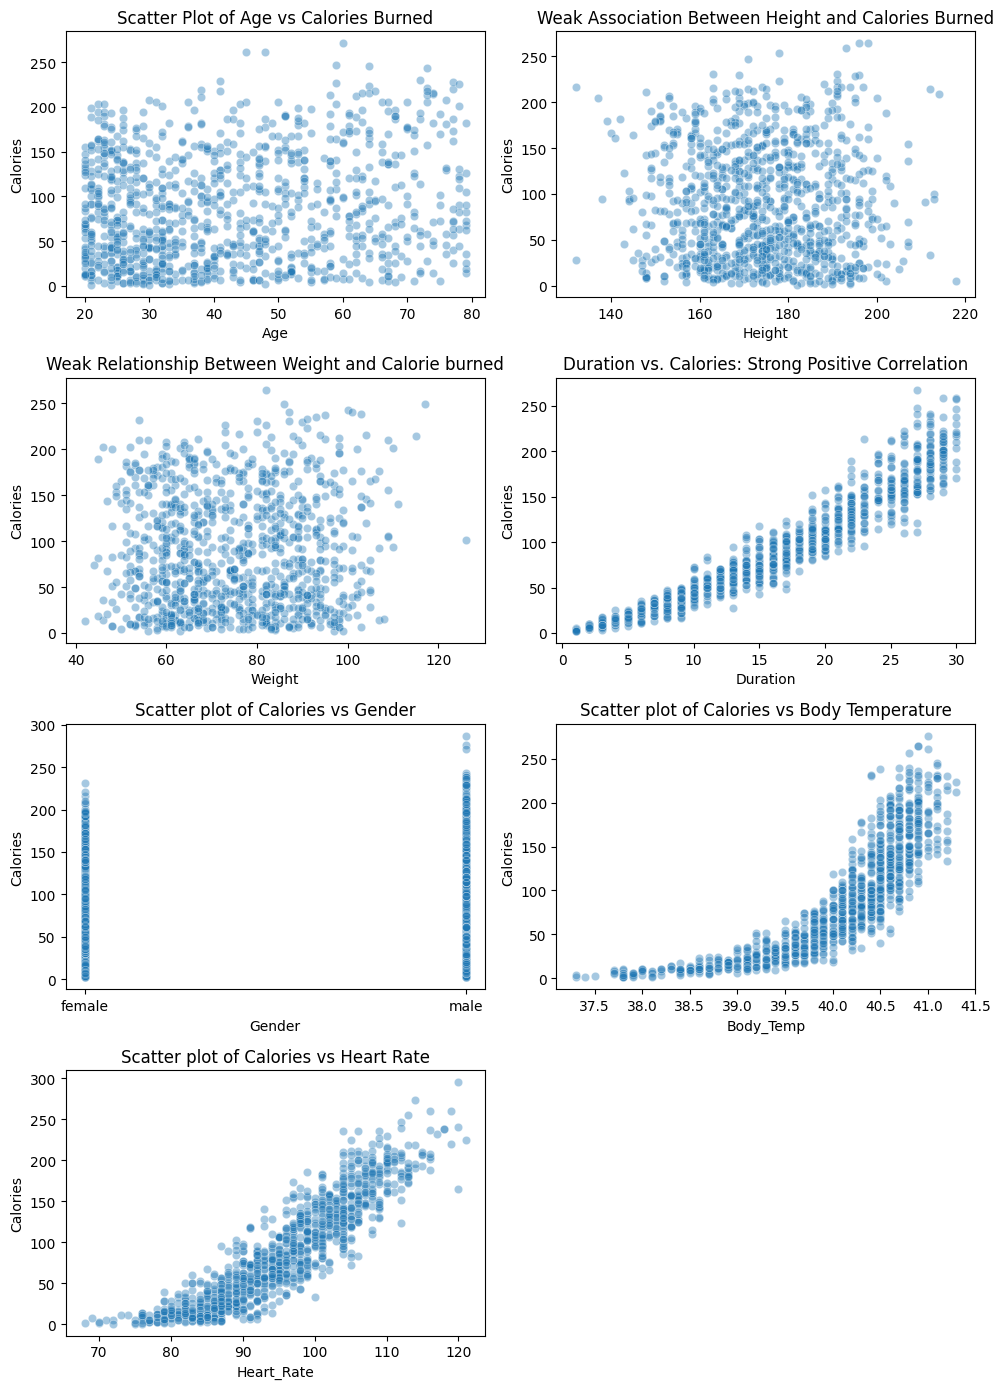

In [ ]:
# Scatterplot for each of the features with Calories

features = ['Age', 'Height', 'Weight', 'Duration', 'Gender', 'Body_Temp', 'Heart_Rate']

custom_titles = [
    'Scatter Plot of Age vs Calories Burned',
    'Weak Association Between Height and Calories Burned',
    'Weak Relationship Between Weight and Calorie burned',
    'Duration vs. Calories: Strong Positive Correlation',
    'Scatter plot of Calories vs Gender',
    'Scatter plot of Calories vs Body Temperature',
    'Scatter plot of Calories vs Heart Rate'
]

plt.figure(figsize=(10, 14))

for i, (col, title) in enumerate(zip(features, custom_titles), 1):
    plt.subplot(4, 2, i)
    x = calories_df.sample(1000)
    sb.scatterplot(x=col, y='Calories', data=x, alpha=0.4) # Value alpha 0.4 makes dense regions dark
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Calories')

plt.tight_layout()
plt.show()


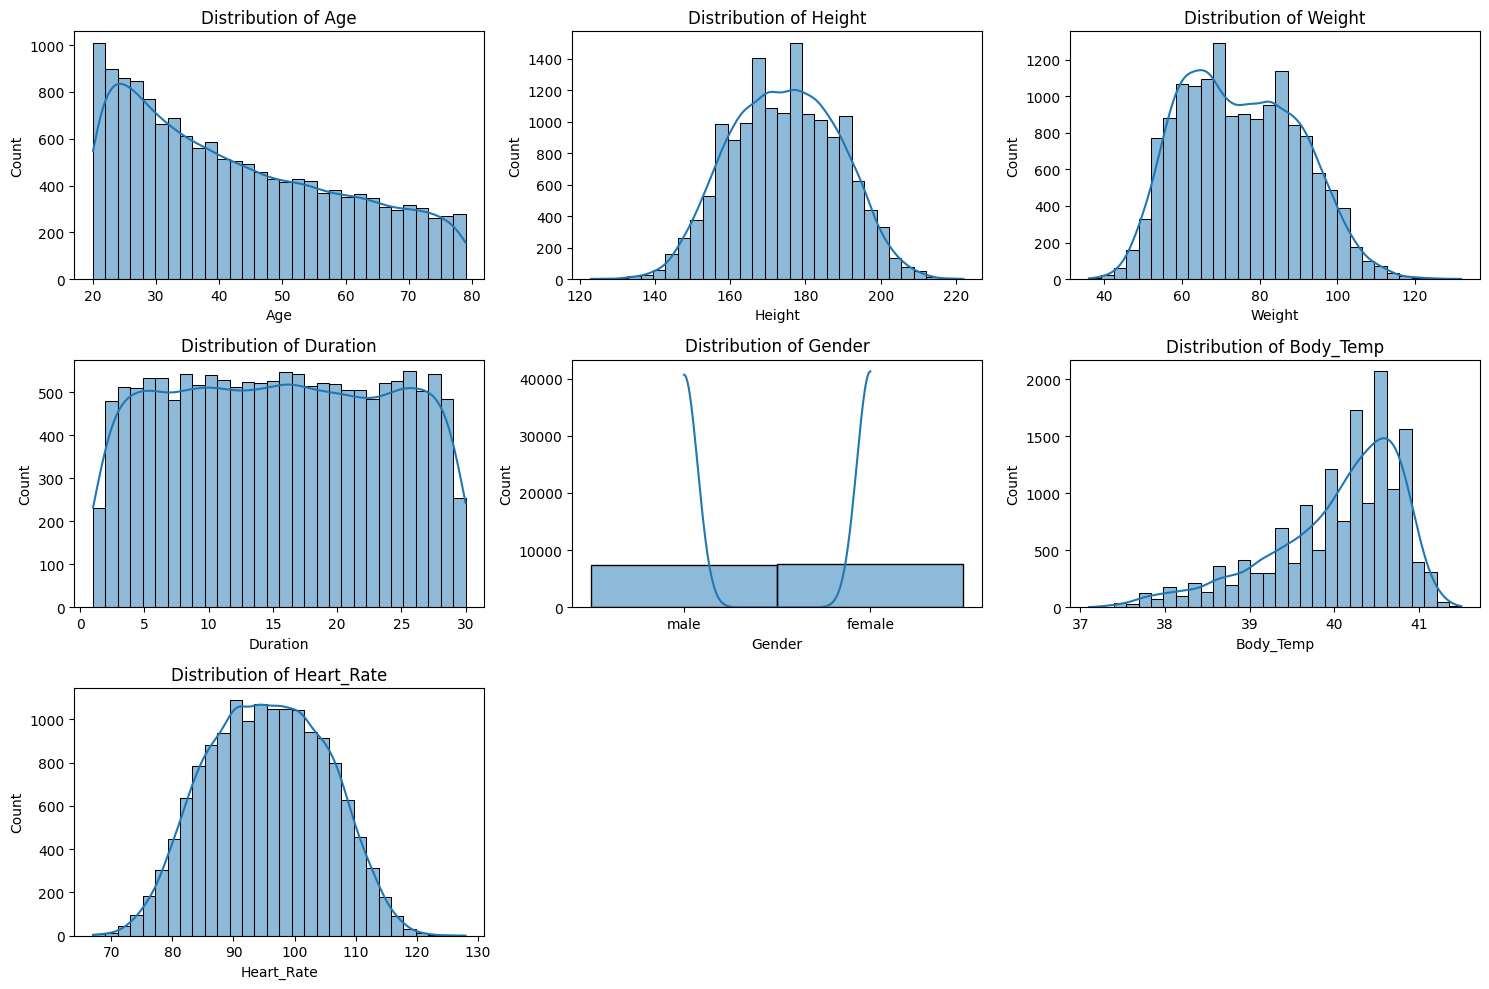

In [ ]:
plt.figure(figsize=(15, 10))

# histograms plot through features for outlier detection
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sb.histplot(calories_df[feature], bins=30, kde=True)  # kde=True adds a density curve
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
# encoding

calories_df.replace({'male': 0, 'female': 1},
           inplace=True)
calories_df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,1,27,154.0,58.0,10.0,81.0,39.8,35.0


In [ ]:
print(calories_df['Gender'].value_counts()[0]) # males
print(calories_df['Gender'].value_counts()[1]) # females

7447
7553


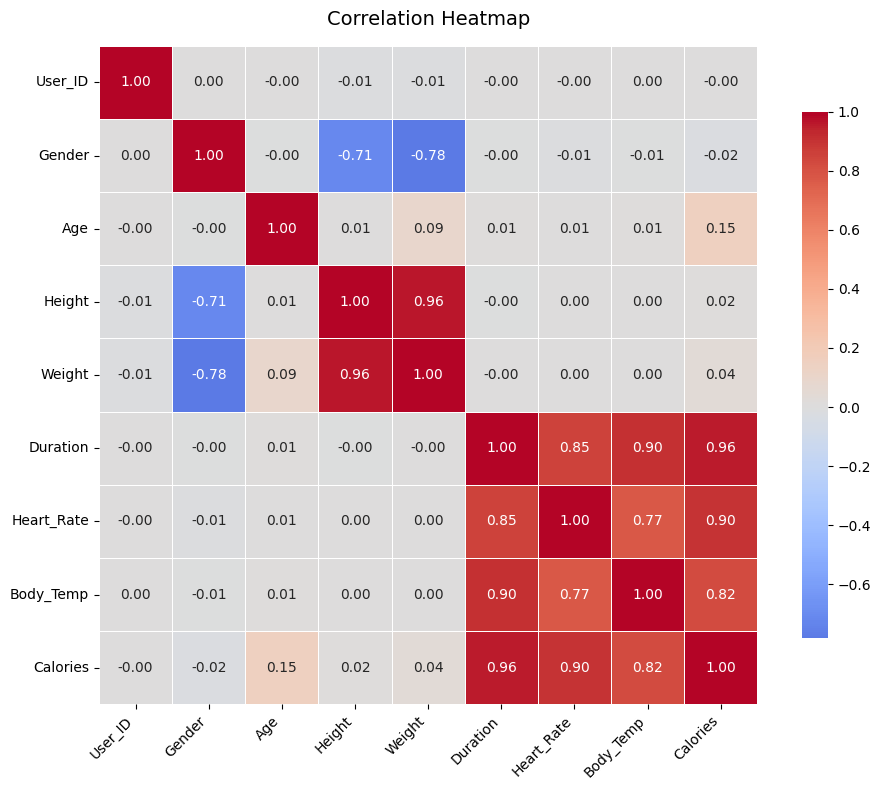

In [ ]:
# Correlation matrix to see relations between features

correlation_matrix = calories_df.corr(numeric_only=True)

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap", fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:

features = calories_df.drop(['User_ID', 'Calories'], axis=1)
target = calories_df['Calories'].values


# Splitting data
# Train-test split 80-20
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((12000, 7), (3000, 7))

In [ ]:
# Feature-Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Machine Learning Models (ML)
Trained the following models:**

---



Linear Regression
XGBoost
Gradient Boosting
Random Forest
K-Nearest Neighbors

Evaluated models using:

R² Score
RMSE
Computation Time

In [ ]:
ml_results, dl_results = [], []

models = {'Linear Regression': LinearRegression(),
          'XGBoost': XGBRegressor(),
          'GBR': GradientBoostingRegressor(),
          'KNN': KNeighborsRegressor(),
          'Random': RandomForestRegressor()}

trained_models = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    time_taken = end_time - start_time
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    ml_results.append({'Model': name, 'R^2 Score': r2, 'RMSE': rmse, 'Time (s)': end_time - start_time})
    trained_models[name] = model

    print(f"Model: {name}")
    print(f"R^2 Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Time Taken: {time_taken:.2f} seconds\n")


Model: Linear Regression
R^2 Score: 0.9673
RMSE: 11.4889
Time Taken: 0.05 seconds

Model: XGBoost
R^2 Score: 0.9989
RMSE: 2.1375
Time Taken: 3.05 seconds

Model: GBR
R^2 Score: 0.9968
RMSE: 3.6121
Time Taken: 2.23 seconds

Model: KNN
R^2 Score: 0.9876
RMSE: 7.0659
Time Taken: 0.09 seconds

Model: Random
R^2 Score: 0.9982
RMSE: 2.6712
Time Taken: 9.34 seconds



In [ ]:
#print(calories_df.dtypes)


In [ ]:
#print(X['Height'].unique())


# **DL Model**

**Keras Sequential Model**

Deep Learning Models (DL)

1. Keras Sequential Model (3 hidden layers, ReLU, Dropout)

Metrics: R², RMSE, Time

In [ ]:
# Building Deep Learning Model with 3 hidden layers

dl_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

dl_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start_time = time.time()
dl_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
end_time = time.time()

y_pred_dl = dl_model.predict(X_test_scaled).flatten()
r2_dl = r2_score(y_test, y_pred_dl)
rmse_dl = np.sqrt(mean_squared_error(y_test, y_pred_dl))
time_dl = end_time - start_time

dl_results.append({'Model': 'Deep Learning', 'R^2 Score': r2_dl, 'RMSE': rmse_dl, 'Time (s)': time_dl})

print(f"Deep Learning Model \n")
print(f"R^2 Score: {r2_dl:.4f}")
print(f"RMSE: {rmse_dl:.4f}")
print(f"Time Taken: {time_dl:.2f} seconds")


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deep Learning Model 

R^2 Score: 0.9987
RMSE: 2.2486
Time Taken: 37.31 seconds


**Comaprison**

In [ ]:
ml_df = pd.DataFrame(ml_results)
dl_df = pd.DataFrame(dl_results)

print("\n *Machine Learning Models Comparison \n")
print(ml_df)

print("\n *Deep Learning Model Comparison \n")
print(dl_df)
print()


 *Machine Learning Models Comparison 

               Model  R^2 Score       RMSE  Time (s)
0  Linear Regression   0.967294  11.488940  0.045277
1            XGBoost   0.998868   2.137512  3.051164
2                GBR   0.996767   3.612132  2.234066
3                KNN   0.987629   7.065863  0.094709
4             Random   0.998232   2.671245  9.344615

 *Deep Learning Model Comparison 

           Model  R^2 Score      RMSE   Time (s)
0  Deep Learning   0.998747  2.248551  37.312289



**Shap** XAI

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
print(len(X_test))


3000


In [ ]:
# A small sample for SHAP to speed up computation
# 300 test samples

sample_X = X_test.sample(300, random_state=42)
sample_X_scaled = X_test_scaled[X_test.index.isin(sample_X.index)]

Shap for ML

Shap for DL model

***Feature Importance Plots***

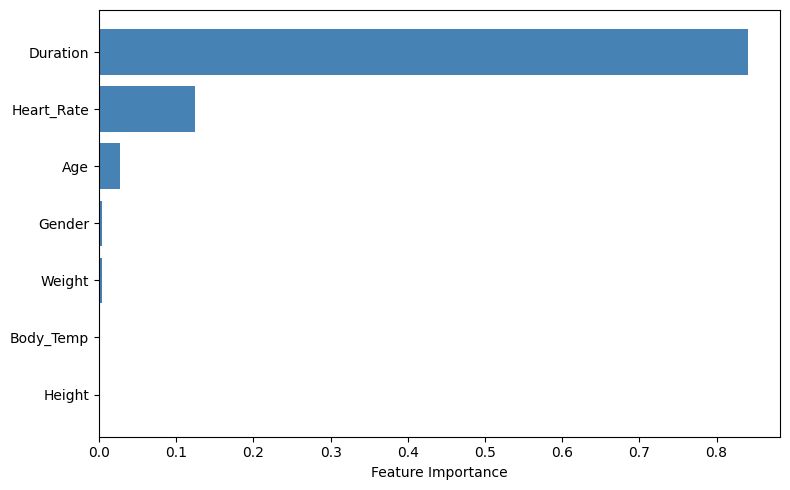

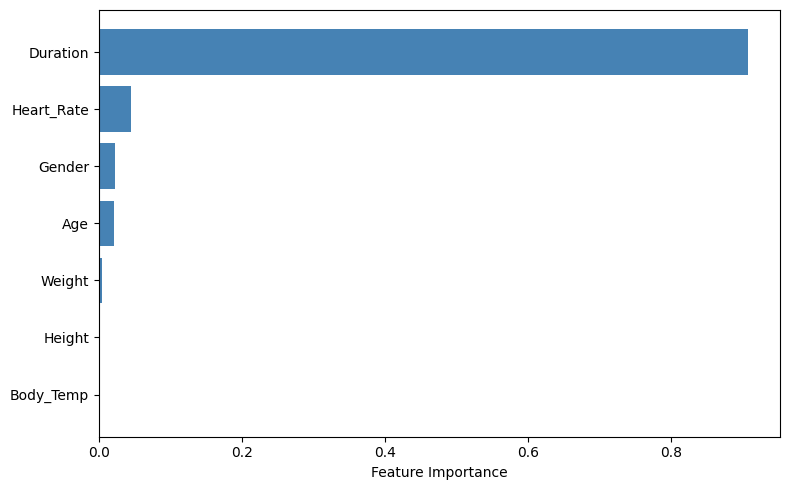

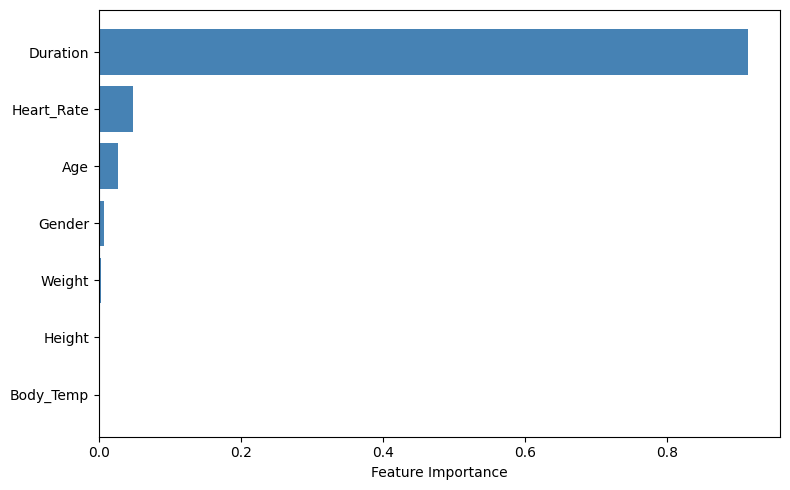

In [ ]:
# Feature Importance Plots

def plot_builtin_importance(model, X_train):
    importances = model.feature_importances_  # Extracting built-in feature importance
    features = X_train.columns

    # Dataframe pairing each feature with the importance score
    feature_imp = pd.DataFrame({
        "Feature": features,
        "Importance": importances
    }).sort_values(by="Importance", ascending=True)  # Least important feature at end

    plt.figure(figsize=(8, 5))
    plt.barh(feature_imp["Feature"], feature_imp["Importance"], color="steelblue")
    plt.xlabel("Feature Importance")
    plt.tight_layout()
    plt.show()

plot_builtin_importance(trained_models["GBR"], X_train)
plot_builtin_importance(trained_models["XGBoost"], X_train)
plot_builtin_importance(trained_models["Random"], X_train)

In [ ]:
# # Define age bins and labels
# age_bins = [0, 25, 40, 60, 100]
# age_labels = ['<25', '25-40', '40-60', '60+']

In [ ]:
# # Create the AgeGroup column
# calories_df['AgeGroup'] = pd.cut(calories_df['Age'], bins=age_bins, labels=age_labels)

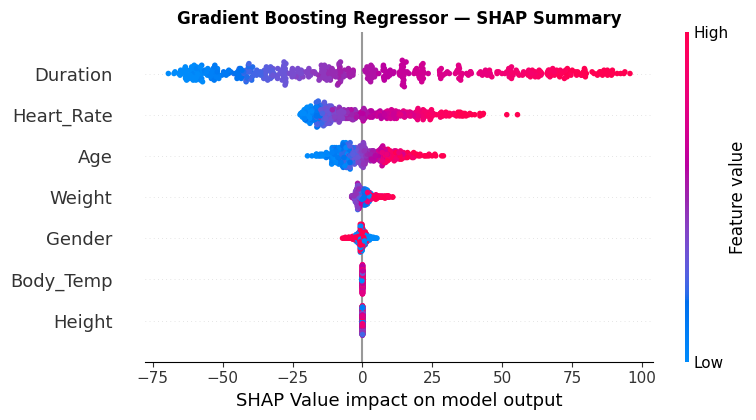

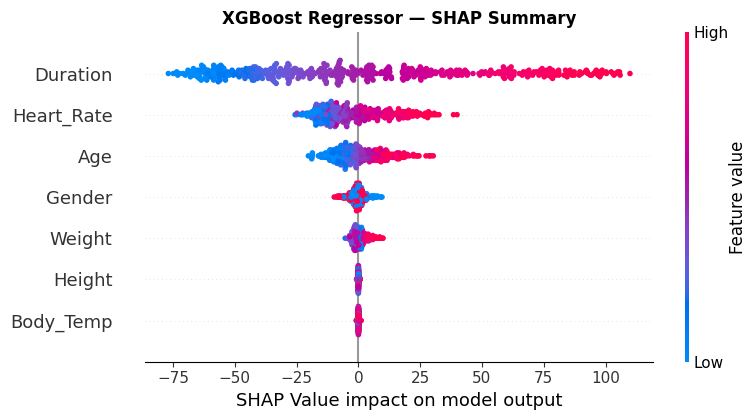

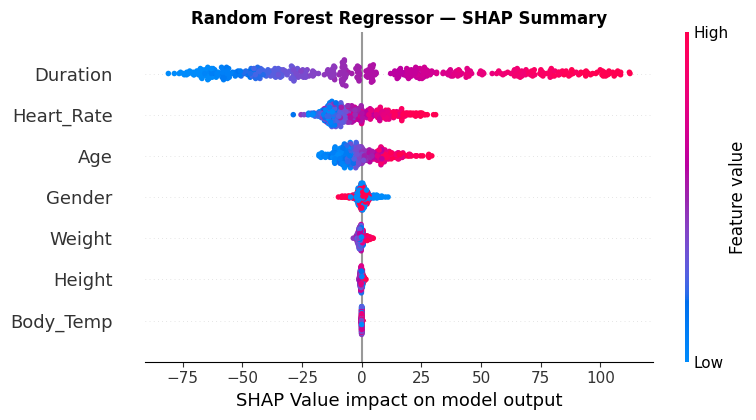

In [ ]:
# SHAP Summary Plots ML models

def shap_beeswarm_tree(model, X_train_df, X_test_df, model_name="Tree Model"):
    train_var, test_var = X_train_df.values, X_test_df.values     # DataFrames to NumPy arrays
    bg, samp = train_var[:200], test_var[:500]       #first 200 rows for SHAP's baseline, 500 rows only for speed

    expl = shap.TreeExplainer(model)
    shap_values = expl.shap_values(samp)

    # Normalization of SHAP values to n_samples, n_features
    shap_values = np.asarray(shap_values)
    if shap_values.ndim == 3 and shap_values.shape[-1] == 1:
        shap_values = shap_values[..., 0]
    shap_values = np.squeeze(shap_values)

    # Beeswarm plot
    shap.summary_plot(
        shap_values,
        features=X_test_df.iloc[:shap_values.shape[0]],
        feature_names=list(X_test_df.columns),
        show=False
    )
    plt.title(f"{model_name} — SHAP Summary", fontsize=12, fontweight="bold")
    plt.xlabel("SHAP Value impact on model output")
    plt.tight_layout()
    plt.show()

# Running for Tree-based models

shap_beeswarm_tree(trained_models["GBR"], X_train, X_test, "Gradient Boosting Regressor")
shap_beeswarm_tree(trained_models["XGBoost"], X_train, X_test, "XGBoost Regressor")
shap_beeswarm_tree(trained_models["Random"], X_train, X_test, "Random Forest Regressor")


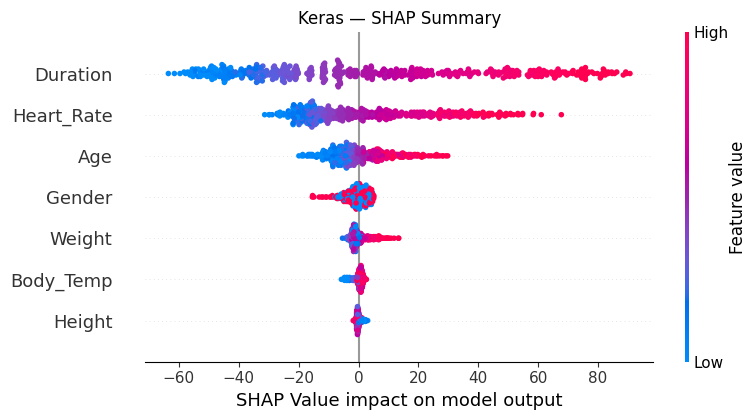

In [ ]:
# SHAP Summary Plot Keras DL model

def shap_beeswarm_dl(model, X_train_scaled, X_test_scaled, X_test_df, title="Keras — SHAP Summary"):
    bg   = X_train_scaled[:200].astype(np.float32)   # background
    samp = X_test_scaled[:500].astype(np.float32)    # sample to explain

    try:
        expl = shap.DeepExplainer(model, bg)  # trying deep-explainer else gradient explainer
    except Exception:
        expl = shap.GradientExplainer((model, model.inputs), bg)

    shapv = expl.shap_values(samp)
    if isinstance(shapv, list): shapv = shapv[0]   # taking the 1st elemnt from the list
    shapv = np.squeeze(shapv)    # SHAP values to n_samples, n_features

    shap.summary_plot(shapv, features=X_test_df.iloc[:shapv.shape[0]], feature_names=list(X_test_df.columns), show=False)
    plt.xlabel("SHAP Value impact on model output")
    plt.title(title);
    plt.tight_layout();
    plt.show()


shap_beeswarm_dl(dl_model, X_train_scaled, X_test_scaled, X_test)


***Removing the Features Age and Gender to check if it has any impact on the Calories prediction !!***




In [ ]:
Age_Gender_feature_drop = features.drop(['Age', 'Gender'], axis=1)


In [ ]:
X_train_red, X_test_red, y_train, y_test = train_test_split(
    Age_Gender_feature_drop, target, test_size=0.2, random_state=42
)


In [ ]:
# Retraining

X_train_scaled_afterdrop = scaler.fit_transform(X_train_red)
X_test_scaled_afterdrop = scaler.transform(X_test_red)

In [ ]:
ml_results, dl_results = [], []

models = {'Linear Regression': LinearRegression(),
          'XGBoost': XGBRegressor(),
          'GBR': GradientBoostingRegressor(),
          'KNN': KNeighborsRegressor(),
          'Random': RandomForestRegressor()}

trained_models = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_red, y_train)
    y_pred = model.predict(X_test_red)
    end_time = time.time()
    time_taken = end_time - start_time
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    ml_results.append({'Model': name, 'R^2 Score': r2, 'RMSE': rmse, 'Time (s)': end_time - start_time})
    trained_models[name] = model

    print(f"Model: {name}")
    print(f"R^2 Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Time Taken: {time_taken:.2f} seconds\n")

Model: Linear Regression
R^2 Score: 0.9504
RMSE: 14.1461
Time Taken: 0.00 seconds

Model: XGBoost
R^2 Score: 0.9681
RMSE: 11.3376
Time Taken: 0.12 seconds

Model: GBR
R^2 Score: 0.9699
RMSE: 11.0159
Time Taken: 0.90 seconds

Model: KNN
R^2 Score: 0.9651
RMSE: 11.8731
Time Taken: 0.04 seconds

Model: Random
R^2 Score: 0.9673
RMSE: 11.4867
Time Taken: 4.03 seconds



In [ ]:
dl_model_afterdrop = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled_afterdrop.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])
dl_model_afterdrop.compile(optimizer='adam', loss='mse')
dl_model_afterdrop.fit(X_train_scaled_afterdrop, y_train, epochs=100, batch_size=32,
                 validation_split=0.2, callbacks=[early_stop], verbose=0)

y_pred_dl_red = dl_model_afterdrop.predict(X_test_scaled_afterdrop).flatten()
r2_dl_red = r2_score(y_test, y_pred_dl_red)
rmse_dl_red = np.sqrt(mean_squared_error(y_test, y_pred_dl_red))
print(f"R² (no Age/Gender): {r2_dl_red:.4f}, RMSE: {rmse_dl_red:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² (no Age/Gender): 0.9718, RMSE: 10.6712


In [ ]:
calories_df

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,1,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...,...
14995,15644082,1,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,17212577,1,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,17271188,1,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,18643037,0,78,193.0,97.0,2.0,84.0,38.3,11.0


In [ ]:
results_df

**GIT Push commands**

In [ ]:
!git config --global user.email 'tarapriyanka0107@gmail.com'
!git config --global user.name 'itsmeptara'


In [ ]:
# testing
#!echo "Hello from Colab"


In [ ]:
# Remember: To manually add the ipynb file in folder
!ls /content


'CaloriesBurnt_MLDL_(5).ipynb'	 calories_dataset   sample_data
 calories-burnt-prediction.zip	 kaggle.json


In [ ]:
!git clone https://github.com/itsmeptara/Masters_DA_Calories-Burnt-Prediction.git


Cloning into 'Masters_DA_Calories-Burnt-Prediction'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 2), reused 2 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 1.08 MiB | 18.78 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
!cp "/content/CaloriesBurnt_MLDL_(5).ipynb" /content/Masters_DA_Calories-Burnt-Prediction/


In [ ]:
%cd /content/Masters_DA_Calories-Burnt-Prediction


/content/Masters_DA_Calories-Burnt-Prediction


In [ ]:
!git reset --soft HEAD~1

In [ ]:
!git add .

!git commit -m "Added updated notebook version"

[main 189b6a6] Added updated notebook version
 1 file changed, 3051 insertions(+)
 create mode 100644 CaloriesBurnt_MLDL_(5).ipynb


In [ ]:
# clearing outputs

!jupyter nbconvert --ClearOutputPreprocessor.enabled=True --inplace "CaloriesBurnt_MLDL_(5).ipynb"

[NbConvertApp] Converting notebook CaloriesBurnt_MLDL_(5).ipynb to notebook
[NbConvertApp] Writing 32117 bytes to CaloriesBurnt_MLDL_(5).ipynb


In [ ]:
!git add 'CaloriesBurnt_MLDL_(5).ipynb'


In [ ]:
!git commit -m "Code update- after clearing token"


[main 02f4cd7] Code update- after clearing token
 1 file changed, 1280 insertions(+), 3051 deletions(-)
 rewrite CaloriesBurnt_MLDL_(5).ipynb (99%)


In [ ]:
!git remote set-url origin https://github.com/itsmeptara/Masters_DA_Calories-Burnt-Prediction.git


In [ ]:
# !git push origin main

fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
import getpass, os

# 0) Identify yourself (if you haven’t)
os.system('git config user.name "itsmeptara"')
os.system('git config user.email "tarapriyanka0107@gmail.com"')

# 1) Read token securely (not echoed)
pat = getpass.getpass("GitHub PAT: ")

# 2) Set a temporary remote that embeds username + token
#    (DO NOT commit this command or its output to your repo)
os.system('git remote set-url origin https://itsmeptara:{}@github.com/itsmeptara/Masters_DA_Calories-Burnt-Prediction.git'.format(pat))

# 3) Push
os.system('git push origin main')

# 4) Immediately restore a clean remote (no credentials in URL)
os.system('git remote set-url origin https://github.com/itsmeptara/Masters_DA_Calories-Burnt-Prediction.git')


GitHub PAT: ··········


0

In [ ]:
!git remote -v

origin	https://github.com/itsmeptara/Masters_DA_Calories-Burnt-Prediction.git (fetch)
origin	https://github.com/itsmeptara/Masters_DA_Calories-Burnt-Prediction.git (push)


In [ ]:
!git fetch origin
!git log --oneline origin/main | head

ac76415 data upload
3a33846 Add files via upload
7fa508a Version1 Colab notebook


In [67]:
!git clone https://github.com/itsmeptara/Masters_DA_Calories-Burnt-Prediction.git

Cloning into 'Masters_DA_Calories-Burnt-Prediction'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 2), reused 2 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 1.08 MiB | 14.20 MiB/s, done.
Resolving deltas: 100% (2/2), done.
